In [1]:
using LinearAlgebra
using Symbolics
using Plots
using Graphs
using GraphPlot

This notebook contains function that takes a graph and parameter rates as inputs and generate the stationary distribution of CRN formed by considering the graph as whole CRN, vertices as speices and edges as Reactions; just like we saw in Chapter5VOL2 while using Bipartite graph.

In [5]:
# N-species Chemical Reaction Network from graph
function N_species_CRN_graph(graph::SimpleGraph, N::Int64, rates_fwd::Dict{Tuple{Int64, Int64}, T}, rates_bwd::Dict{Tuple{Int64, Int64}, T}) where T<:Real
    num_states = 2^N  # Total number of possible binary states
    P = zeros(T, num_states, num_states)  # Transition matrix
    # CRN starts
    states = [reverse(digits(i-1, base=2, pad=N)) for i in 1:num_states]
    # Iterate through all states and define transitions
    for i in 1:num_states
        current_state = states[i]
        # Single node transitions: Xi^0 <--> Xi^1 with rate 1
        for v in 1:N
            new_state = copy(current_state)
            new_state[v] = 1 - current_state[v]  # Flip the bit for node v (state transition)
            new_index = 1 + parse(Int, join(new_state), base=2)  # Get the new state index
            # Add transition rate for single vertex flipping
            # Rate is 1 for each node
            P[i, new_index] += 1.0
            P[i, i] -= 1.0  # Update diagonal
        end
        # Coupled transitions based on the graph edges
        for edge in edges(graph)
            i1, j1 = src(edge), dst(edge)  # Vertices of the edge (i1, j1)

            # Forward coupled transition: Xi^1 + Xj^0 -> Xi^1 + Xj^1
            if current_state[i1] == 1 && current_state[j1] == 0
                new_state = copy(current_state)
                new_state[j1] = 1  # Flip the j1-th bit
                new_index = 1 + parse(Int, join(new_state), base=2)
                rate_fwd = get(rates_fwd, (i1, j1), 0.0)  # Forward transition rate
                P[i, new_index] += rate_fwd  # Forward transition
                P[i, i] -= rate_fwd  # Update diagonal
            # Backward coupled transition: Xi^1 + Xj^1 -> Xi^1 + Xj^0
            elseif current_state[i1] == 1 && current_state[j1] == 1
                new_state = copy(current_state)
                new_state[j1] = 0  # Flip the j1-th bit back
                new_index = 1 + parse(Int, join(new_state), base=2)
                rate_bwd = get(rates_bwd, (i1, j1), 0.0)  # Backward transition rate
                P[i, new_index] += rate_bwd  # Backward transition
                P[i, i] -= rate_bwd  # Update diagonal
            end
            # If you want to handle (j, i) differently, we repeat for the reverse pair
            # Forward coupled transition: Xj^1 + Xi^0 -> Xj^1 + Xi^1
            if current_state[j1] == 1 && current_state[i1] == 0
                new_state = copy(current_state)
                new_state[i1] = 1  # Flip the i1-th bit
                new_index = 1 + parse(Int, join(new_state), base=2)
                rate_fwd_rev = get(rates_fwd, (j1, i1), 0.0)  # Forward transition rate for reverse pair
                P[i, new_index] += rate_fwd_rev  # Forward transition
                P[i, i] -= rate_fwd_rev  # Update diagonal
            # Backward coupled transition: Xj^1 + Xi^1 -> Xj^1 + Xi^0
            elseif current_state[j1] == 1 && current_state[i1] == 1
                new_state = copy(current_state)
                new_state[i1] = 0  # Flip the i1-th bit back
                new_index = 1 + parse(Int, join(new_state), base=2)
                rate_bwd_rev = get(rates_bwd, (j1, i1), 0.0)  # Backward transition rate for reverse pair
                P[i, new_index] += rate_bwd_rev  # Backward transition
                P[i, i] -= rate_bwd_rev  # Update diagonal
            end
        end
    end
    return P
end

N_species_CRN_graph (generic function with 1 method)

The CRN in graph is assumed to be constructed by Taylor Chemical Boltzmann Machine scheme. We can modify states and the whole CRN according to our problem. This function will generate the transition matrix which will later yield the stationary distribution by applying MCTT over it.

In [6]:
# Example usage
N = 3  # Number of nodes
g = SimpleGraph(N)  # Create an empty graph with N nodes
add_edge!(g, 1, 2)  # Add edge between vertex 1 and 2
add_edge!(g, 2, 3)  # Add edge between vertex 2 and 3
# Define forward and backward rates
rates_fwd = Dict((1, 2) => 1.0, (2, 1) => 1.0, (2, 3) => 1.5, (3, 2) => 1.5)
rates_bwd = Dict((1, 2) => 3.0, (2, 1) => 3.0, (2, 3) => 7.5, (3, 2) => 7.5)
# Generate transition matrix
P = N_species_CRN_graph(g, N, rates_fwd, rates_bwd)
P 

8×8 Matrix{Float64}:
 -3.0   1.0   1.0    0.0   1.0   0.0    0.0    0.0
  1.0  -4.5   0.0    2.5   0.0   1.0    0.0    0.0
  1.0   0.0  -5.5    2.5   0.0   0.0    2.0    0.0
  0.0   8.5   8.5  -19.0   0.0   0.0    0.0    2.0
  1.0   0.0   0.0    0.0  -4.0   1.0    2.0    0.0
  0.0   1.0   0.0    0.0   1.0  -5.5    0.0    3.5
  0.0   0.0   4.0    0.0   4.0   0.0  -10.5    2.5
  0.0   0.0   0.0    4.0   0.0  11.5    8.5  -24.0

Visual Implementation of graph

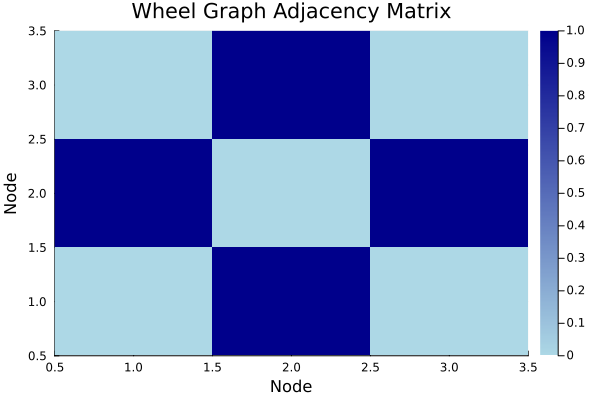

In [7]:
# Get adjacency matrix for plotting
adj_matrix = adjacency_matrix(g)
# Visualize using Plots
heatmap(adj_matrix, color=:blues, title="Wheel Graph Adjacency Matrix", xlabel="Node", ylabel="Node")

Generating Stationary distribution of CRN formed by this graph

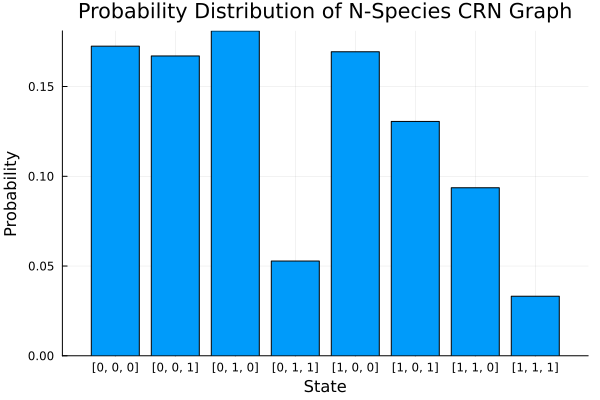

In [9]:
z=[]
n=2^N
for i in 1:n
    minor = P[[1:i-1; i+1:n], [1:i-1; i+1:n]]
    pi = det(minor)
    push!(z,pi)
end
s = sum(z)
z = [zi/s for zi in z]
num_states=n
states = [reverse(digits(i-1, base=2, pad=N)) for i in 1:num_states]
labels = [string(states[i]) for i in 1:length(states)]
display(bar(labels, z, xlabel="State", ylabel="Probability", legend=false, title="Probability Distribution of N-Species CRN Graph"))

Considering another Graph

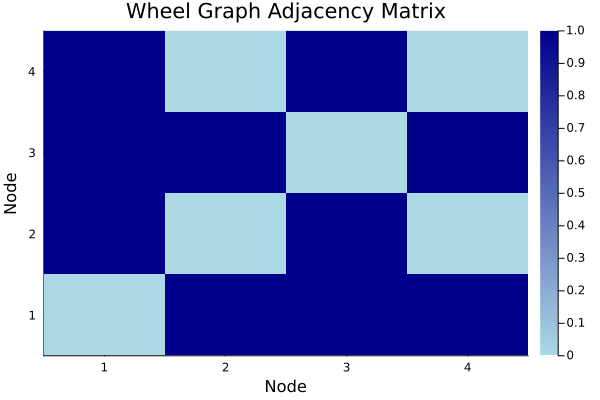

In [12]:
N1=4
g1=SimpleGraph(N1)
add_edge!(g1,1,2)
add_edge!(g1,1,3)
add_edge!(g1,1,4)
add_edge!(g1,2,3)
add_edge!(g1,3,4)
# Get adjacency matrix for plotting
adj_matrix1 = adjacency_matrix(g1)
# Visualize using Plots
heatmap(adj_matrix1, color=:blues, title="Wheel Graph Adjacency Matrix", xlabel="Node", ylabel="Node")

In [13]:
rates_fwd1 = Dict((1,2) => 1.0,(2,1) => 1.0,(1,3) => 1.5,(3,1) => 1.5,(1,4) => 2.0,(4,1) => 2.0,(2,3) => 0.8,(3,2) => 0.8,(2,4) => 1.2,(4,2) => 1.2,(3,4) => 1.0,(4,3) => 1.0)
rates_bwd1 = Dict((1,2) => 3.0,(2,1) => 3.0,(1,3) => 2.5,(3,1) => 2.5,(1,4) => 1.5,(4,1) => 1.5,(2,3) => 2.0,(3,2) => 2.0,(2,4) => 2.5,(4,2) => 2.5,(3,4) => 3.5,(4,3) => 3.5)
P1 = N_species_CRN_graph(g1, N1, rates_fwd1, rates_bwd1)
P1

16×16 Matrix{Float64}:
 -4.0   1.0   1.0    0.0   1.0   0.0  …    0.0    0.0    0.0    0.0    0.0
  1.0  -7.0   0.0    2.0   0.0   1.0       0.0    0.0    0.0    0.0    0.0
  1.0   0.0  -7.3    2.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   4.5   4.5  -15.3   0.0   0.0       4.5    0.0    0.0    0.0    0.0
  1.0   0.0   0.0    0.0  -5.8   1.0       0.0    2.0    0.0    0.0    0.0
  0.0   1.0   0.0    0.0   1.0  -8.8  …    0.0    0.0    4.0    0.0    0.0
  0.0   0.0   3.0    0.0   3.0   0.0       0.0    0.0    0.0    3.5    0.0
  0.0   0.0   0.0    3.0   0.0   6.5       0.0    0.0    0.0    0.0    5.5
  1.0   0.0   0.0    0.0   0.0   0.0       0.0    2.0    0.0    0.0    0.0
  0.0   2.5   0.0    0.0   0.0   0.0       3.5    0.0    2.0    0.0    0.0
  0.0   0.0   3.5    0.0   0.0   0.0  …    4.0    0.0    0.0    2.8    0.0
  0.0   0.0   0.0    5.0   0.0   0.0     -20.8    0.0    0.0    0.0    2.8
  0.0   0.0   0.0    0.0   4.0   0.0       0.0  -14.3    3.0    3.3    0.0
  

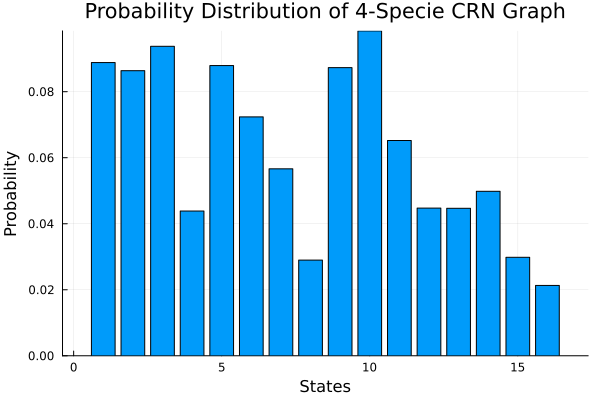

In [16]:
z1=[]
n1=2^N1
for i in 1:n1
    minor = P1[[1:i-1; i+1:n1], [1:i-1; i+1:n1]]
    pi = det(minor)
    push!(z1,pi)
end
s = sum(z1)
z1 = [zi/s for zi in z1]
num_states=n1
states = [reverse(digits(i-1, base=2, pad=N1)) for i in 1:num_states]
labels = [i for i in 1:length(states)]
display(bar(labels, z1, xlabel="States", ylabel="Probability", legend=false, title="Probability Distribution of 4-Specie CRN Graph"))